In [13]:
import fire
from esm_ecn.model import LitSAE
from esm_ecn.data import train_data_loader, val_data_loader, test_data_loader
from esm_ecn.train import setup_experiment, load_checkpoint
from esm_ecn.constants import DATA_FOLDER
import matplotlib.pyplot as plt

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f07dc176650>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7f07ce96a860, raw_cell="import fire
from esm_ecn.model import LitSAE
from .." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2Bkraken/home/ishan/esm-ecn/notebooks/sae_pred.ipynb#W0sdnNjb2RlLXJlbW90ZQ%3D%3D>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f07dc176650>> (for post_run_cell), with arguments args (<ExecutionResult object at 7f07ce96aa10, execution_count=13 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7f07ce96a860, raw_cell="import fire
from esm_ecn.model import LitSAE
from .." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2Bkraken/home/ishan/esm-ecn/notebooks/sae_pred.ipynb#W0sdnNjb2RlLXJlbW90ZQ%3D%3D> result=None>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

In [ ]:
model_type = "esmc_300m"
batch_size = 2048
cls = True
experiment_name = "default"
project = "esm_cls_SAE"
resume = False
best=False
wandb_debug = True
accelerator = "cuda"
epochs = 10
dict_exp = 256
sparsity = 0.00

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f07dc176650>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7f07ce96afb0, raw_cell="model_type = "esmc_300m"
batch_size = 2048
cls = T.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2Bkraken/home/ishan/esm-ecn/notebooks/sae_pred.ipynb#W1sdnNjb2RlLXJlbW90ZQ%3D%3D>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f07dc176650>> (for post_run_cell), with arguments args (<ExecutionResult object at 7f07ce96a3b0, execution_count=14 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7f07ce96afb0, raw_cell="model_type = "esmc_300m"
batch_size = 2048
cls = T.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2Bkraken/home/ishan/esm-ecn/notebooks/sae_pred.ipynb#W1sdnNjb2RlLXJlbW90ZQ%3D%3D> result=None>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

In [15]:
train_loader = train_data_loader(model_type, batch_size, cls)
val_loader = val_data_loader(model_type, batch_size, cls)
test_loader = test_data_loader(model_type, batch_size, cls)

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f07dc176650>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7f07ce7b3790, raw_cell="train_loader = train_data_loader(model_type, batch.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2Bkraken/home/ishan/esm-ecn/notebooks/sae_pred.ipynb#W2sdnNjb2RlLXJlbW90ZQ%3D%3D>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

Loading train embeddings
Loaded embeddings, shape: torch.Size([178302, 960])
Loading train labels
Loaded labels, shape: torch.Size([178302, 4793])
Loading dev embeddings
Loaded embeddings, shape: torch.Size([23010, 960])
Loading dev labels
Loaded labels, shape: torch.Size([23010, 4793])
Loading test embeddings
Loaded embeddings, shape: torch.Size([22183, 960])
Loading test labels
Loaded labels, shape: torch.Size([22183, 4793])
Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f07dc176650>> (for post_run_cell), with arguments args (<ExecutionResult object at 7f07ce7b3f10, execution_count=15 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7f07ce7b3790, raw_cell="train_loader = train_data_loader(model_type, batch.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2Bkraken/home/ishan/esm-ecn/notebooks/sae_pred.ipynb#W2sdnNjb2RlLXJlbW90ZQ%3D%3D> result=None>,),kwargs

BrokenPipeError: [Errno 32] Broken pipe

In [ ]:
input_dim = train_loader.dataset[0][0].shape[0]
model = LitSAE(model_dim=input_dim, dict_dim=dict_exp * input_dim, sparsity_coefficient=sparsity)

trainer, experiment_name = setup_experiment(experiment_name, project, resume, wandb_debug, accelerator, epochs)
print(experiment_name)
checkpoint_path = DATA_FOLDER / 'checkpoints' / experiment_name / 'best-checkpoint.ckpt'

if resume:
    model = load_checkpoint(checkpoint_path.parent, SAE=True, model_dim=input_dim, dict_dim=dict_exp * input_dim, best=best)


Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f07dc176650>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7f07ce7b66b0, raw_cell="input_dim = train_loader.dataset[0][0].shape[0]
mo.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2Bkraken/home/ishan/esm-ecn/notebooks/sae_pred.ipynb#W3sdnNjb2RlLXJlbW90ZQ%3D%3D>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

In [ ]:
trainer.fit(model, train_loader, val_loader)

You are using a CUDA device ('NVIDIA RTX 6000 Ada Generation') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING `resume` will be ignored since W&B syncing is set to `offline`. Starting a new run with run id default.


/home/ishan/miniforge3/envs/ecn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /data/ishan/ecn/checkpoints/default exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type   | Params | Mode 
----------------------------------------------
0 | encoder_DF | Linear | 59.0 M | train
1 | decoder_FD | Linear | 59.0 M | train
----------------------------------------------
118 M     Trainable params
0         Non-trainable params
118 M     Total params
472.109   Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 21.84it/s]

/home/ishan/miniforge3/envs/ecn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.
/home/ishan/miniforge3/envs/ecn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:213: You called `self.log('val/dead_codes', ...)` in your `validation_step` but the value needs to be floating to be reduced. Converting it to torch.float32. You can silence this warning by converting the value to floating point yourself. If you don't intend to reduce the value (for instance when logging the global step or epoch) then you can use `self.logger.log_metrics({'val/dead_codes': ...})` instead.


/home/ishan/miniforge3/envs/ecn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Epoch 0:   0%|          | 0/88 [00:00<?, ?it/s] 

/home/ishan/miniforge3/envs/ecn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:213: You called `self.log('train/dead_codes', ...)` in your `training_step` but the value needs to be floating to be reduced. Converting it to torch.float32. You can silence this warning by converting the value to floating point yourself. If you don't intend to reduce the value (for instance when logging the global step or epoch) then you can use `self.logger.log_metrics({'train/dead_codes': ...})` instead.


Epoch 2: 100%|██████████| 88/88 [00:09<00:00,  9.44it/s, v_num=ault, train/loss=0.0357, train/reconstruction=0.0357, train/dead_codes=1.000, val/loss=0.0481, val/reconstruction=0.0481, val/sparsity=6.1e+4, val/dead_codes=0.000, train/sparsity=6.1e+4] 

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 88/88 [00:39<00:00,  2.21it/s, v_num=ault, train/loss=0.0357, train/reconstruction=0.0357, train/dead_codes=1.000, val/loss=0.0481, val/reconstruction=0.0481, val/sparsity=6.1e+4, val/dead_codes=0.000, train/sparsity=6.1e+4]


In [ ]:
# model = LitSAE.load_from_checkpoint(checkpoint_path, model_dim=input_dim, dict_dim=dict_exp * input_dim, sparsity_coefficient=sparsity)
trainer.test(model, test_loader)

/home/ishan/miniforge3/envs/ecn/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/ishan/miniforge3/envs/ecn/lib/python3.10/site- ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ishan/miniforge3/envs/ecn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Testing DataLoader 0:  36%|███▋      | 4/11 [00:00<00:00, 41.75it/s] 

/home/ishan/miniforge3/envs/ecn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:213: You called `self.log('test/dead_codes', ...)` in your `test_step` but the value needs to be floating to be reduced. Converting it to torch.float32. You can silence this warning by converting the value to floating point yourself. If you don't intend to reduce the value (for instance when logging the global step or epoch) then you can use `self.logger.log_metrics({'test/dead_codes': ...})` instead.


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 35.00it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test/dead_codes                0.0
        test/loss           0.04896637424826622
   test/reconstruction      0.04896637424826622
      test/sparsity           60966.63671875
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test/loss': 0.04896637424826622,
  'test/reconstruction': 0.04896637424826622,
  'test/sparsity': 60966.63671875,
  'test/dead_codes': 0.0}]

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np
import torch

# Extract features and labels from the train_loader
X_train = []
X_train_dense = []
X_train_og = []
y_train = []
X_test = []
X_test_dense = []
X_test_og = []
y_test = []
with torch.no_grad():
    model.eval()
    model.to('cuda')
    for batch in train_loader:
        features, labels = batch
        x_sparse, x_dense = model(features, stage="test")
        X_train.append(x_sparse.cpu().numpy())
        X_train_dense.append(x_dense.cpu().numpy())
        X_train_og.append(features.cpu().numpy())
        # top_k_codes_BKF = model.top_k(features, k=5)
        y_train.append(labels.cpu().numpy())

    for batch in test_loader:
        features, labels = batch
        x_sparse, x_dense = model(features, stage="test")
        X_test.append(x_sparse.cpu().numpy())
        X_test_dense.append(x_dense.cpu().numpy())
        X_test_og.append(features.cpu().numpy())
        y_test.append(labels.cpu().numpy())

X_train = np.vstack(X_train)
X_train_dense = np.vstack(X_train_dense)
X_train_og = np.vstack(X_train_og)
y_train = np.concatenate(y_train)

# Extract features and labels from the test_loader
X_test = np.vstack(X_test)
X_test_dense = np.vstack(X_test_dense)
X_test_og = np.vstack(X_test_og)
y_test = np.concatenate(y_test)

KeyboardInterrupt: 

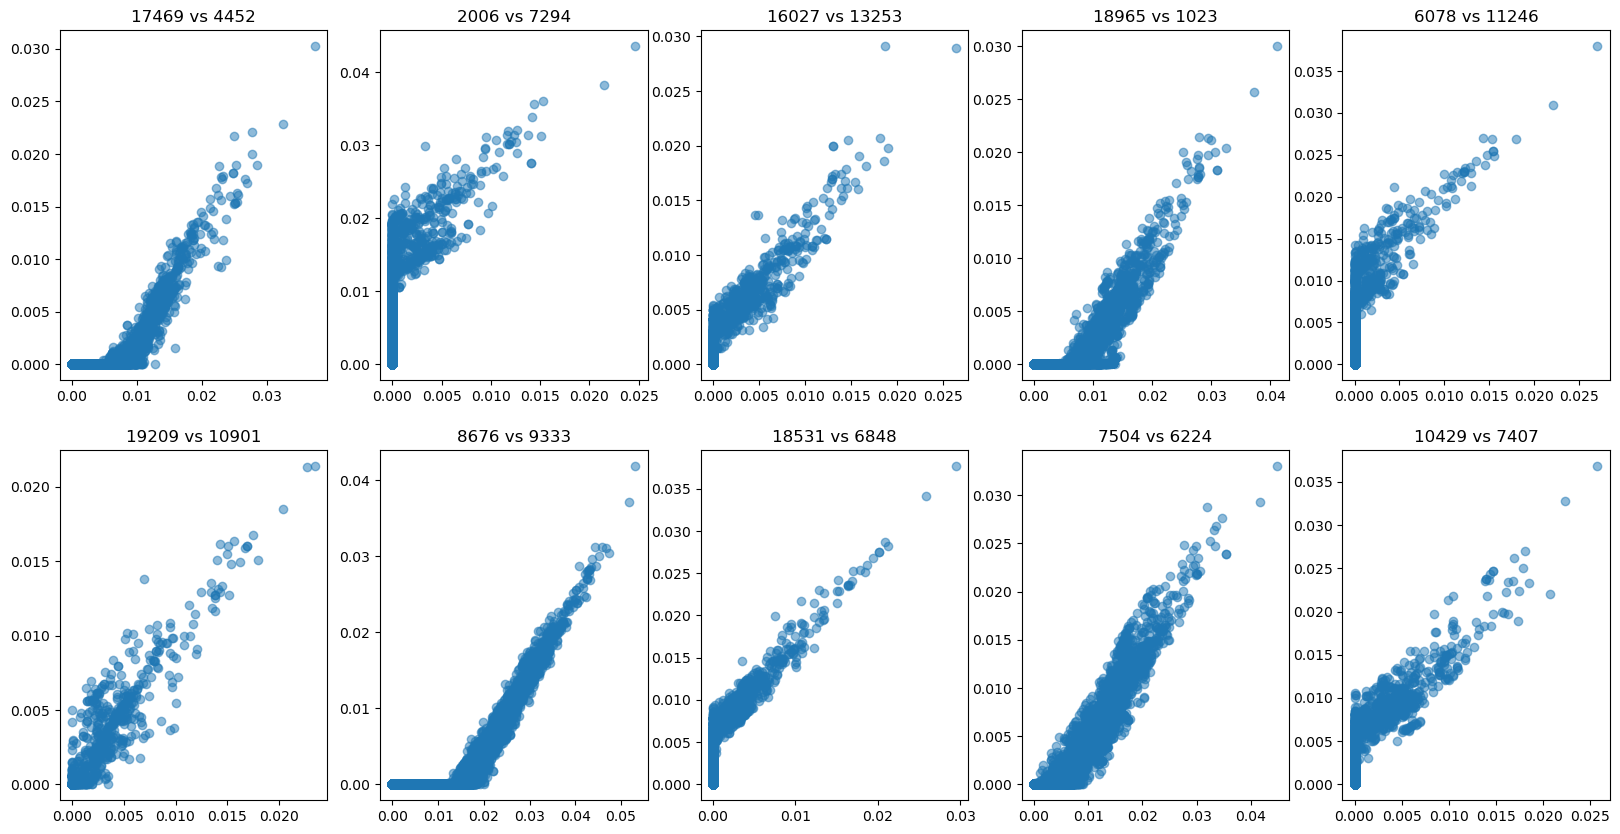

In [ ]:
num_pairs = 10
num_rows = (num_pairs + 1) // 2
fig, axes = plt.subplots(2, num_rows, figsize=(20, 10))
for i in range(num_pairs):
    a, b = np.random.choice(X_train.shape[1], 2, replace=False)
    ax = axes[i // num_rows, i % num_rows]
    # ax.scatter(X_test[:, a], X_test[:, b], alpha=0.5)
    ax.scatter(X_train[:, a], X_train[:, b], alpha=0.5)
    ax.set_title(f"{a} vs {b}")

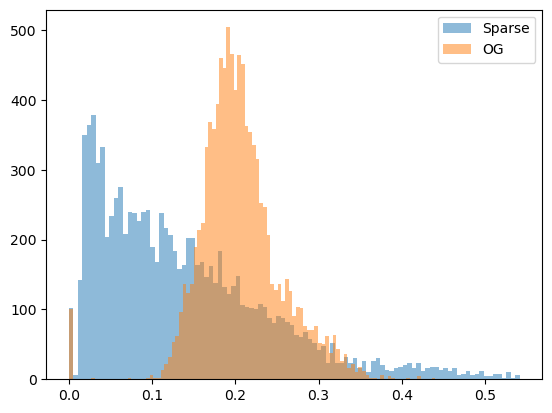

In [ ]:
# plot the different in pairwise distance distributions for 100 random og and sparse vectors
indices = np.random.choice(X_train.shape[0], 100, replace=False)
sparse_distance_mat = torch.cdist(torch.tensor(X_train[indices]), torch.tensor(X_train[indices]))
og_distance_mat = torch.cdist(torch.tensor(X_train_og[indices]), torch.tensor(X_train_og[indices]))
sparse_distance_mat = sparse_distance_mat.flatten().numpy()
og_distance_mat = og_distance_mat.flatten().numpy()
# sparse_distance_mat = sparse_distance_mat.flatten().numpy() / sparse_distance_mat.max()
# og_distance_mat = og_distance_mat.flatten().numpy() / og_distance_mat.max()
plt.figure()
plt.hist(sparse_distance_mat, bins=100, alpha=0.5, label='Sparse')
plt.hist(og_distance_mat, bins=100, alpha=0.5, label='OG')
plt.legend()
plt.show()


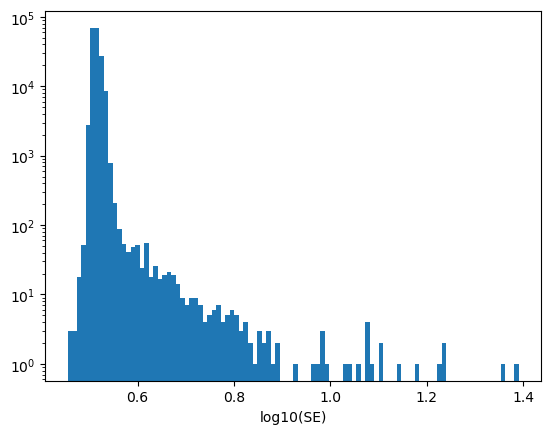

In [ ]:
import matplotlib.pyplot as plt
train_mse = np.sum((X_train_og - X_train_dense) ** 2, axis=1).tolist()
plt.hist(np.log10(train_mse), bins=100)
plt.yscale('log')
plt.xlabel('log10(SE)')
plt.show()

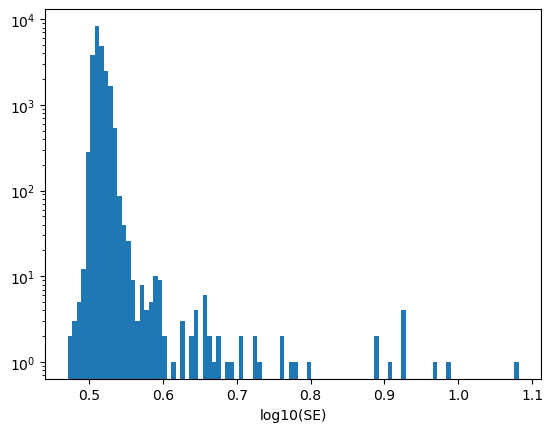

In [ ]:
import matplotlib.pyplot as plt
test_mse = np.sum((X_test_og - X_test_dense) ** 2, axis=1).tolist()
plt.hist(np.log10(test_mse), bins=100)
plt.yscale('log')
plt.xlabel('log10(SE)')
plt.show()

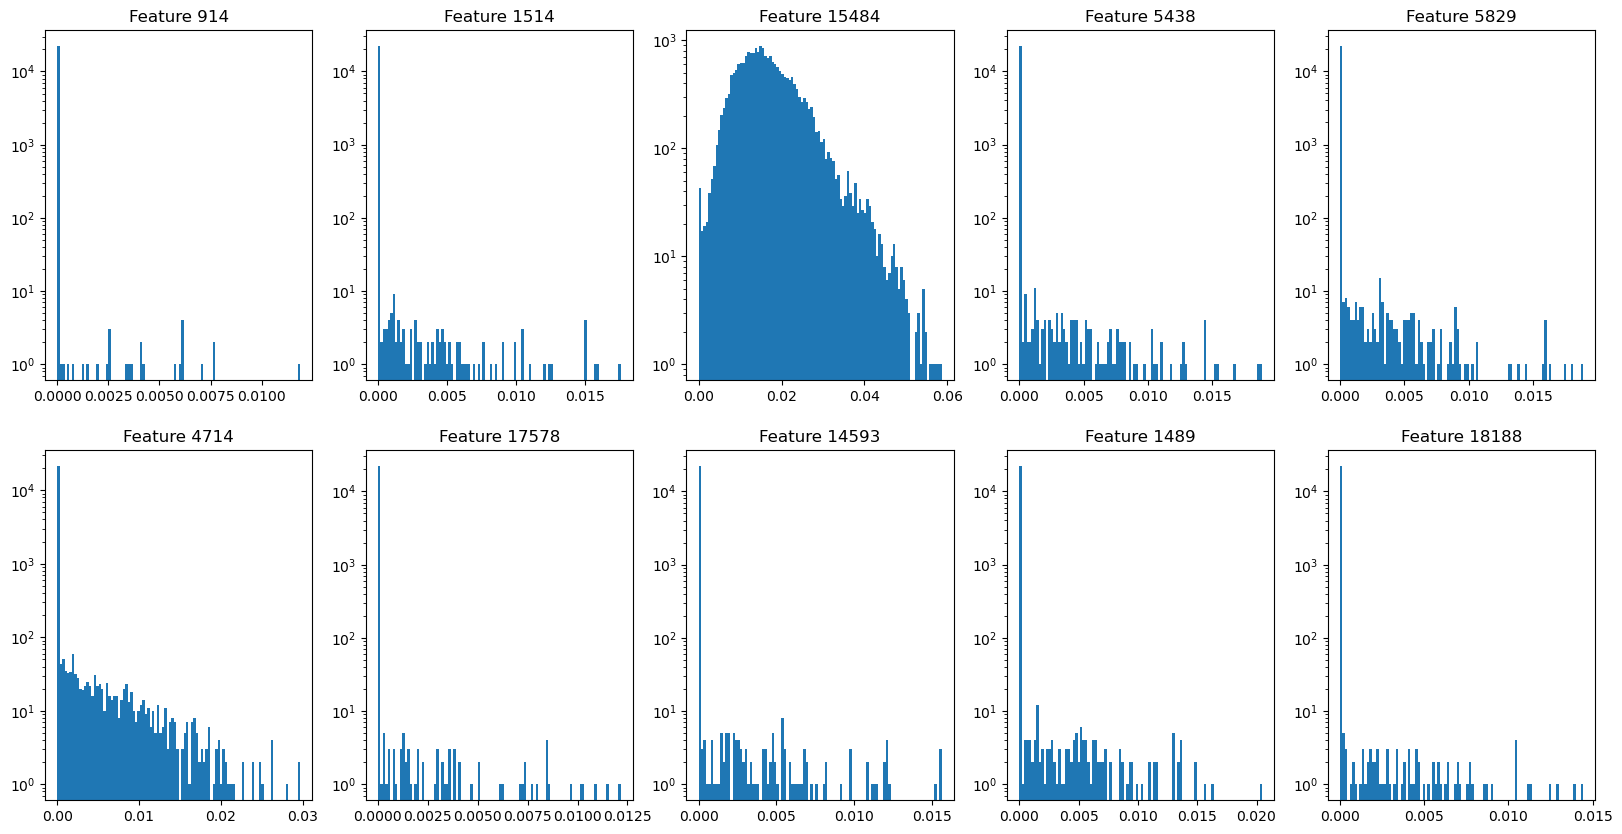

In [ ]:
rand_feat = np.random.choice(X_train.shape[1], 10)
feat_dists = X_test[:, rand_feat]
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
for i, ax in enumerate(axes.flatten()):
    ax.hist(feat_dists[:, i], bins=100)
    ax.set_title(f'Feature {rand_feat[i]}')
    ax.set_yscale('log')

In [ ]:
y_train = torch.tensor([torch.nonzero(torch.tensor(y))[0].item() for y in y_train])
print(y_train.shape)
y_test = torch.tensor([torch.nonzero(torch.tensor(y))[0].item() for y in y_test])
print(y_test.shape)

torch.Size([178302])
torch.Size([22183])


In [ ]:
print(len(torch.unique(y_train)))
labels, counts = torch.unique(y_train, return_counts=True)
final_labels = labels[counts > 20]
print(len(final_labels))

4277
958


In [ ]:
def relabel_labels(labels, final_labels):
    label_map = {label.item(): idx for idx, label in enumerate(final_labels)}
    new_labels = []
    for label in labels:
        if label.item() in label_map:
            new_labels.append(label_map[label.item()])
        else:
            new_labels.append(len(final_labels))
    return torch.tensor(new_labels)

y_train = relabel_labels(y_train, final_labels)
y_test = relabel_labels(y_test, final_labels)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Train a KNN classifier
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train_dense, y_train)

# Predict and evaluate the model
y_pred_knn = knn.predict(X_test_dense)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"KNN Test Accuracy: {accuracy_knn:.4f}")

KNN Test Accuracy: 0.6646


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Train a KNN classifier
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)

# Predict and evaluate the model
y_pred_knn = knn.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"KNN Test Accuracy: {accuracy_knn:.4f}")

KNN Test Accuracy: 0.6993


In [ ]:
# from sklearn.neighbors import KNeighborsClassifier

# # Train a KNN classifier
# knn = KNeighborsClassifier(n_neighbors=10)
# knn.fit(X_train_og, y_train)

# # Predict and evaluate the model
# y_pred_knn = knn.predict(X_test_og)
# accuracy_knn = accuracy_score(y_test, y_pred_knn)
# print(f"KNN Test Accuracy: {accuracy_knn:.4f}")